## **DATA EXTRACTION AND PREPROCESSING**

In [ ]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ====================== 1️⃣ Extract Dataset ======================

dataset_zip = "/content/Skin Disease Classification Dataset.zip"  # Change this if needed
extract_path = "/content/skin_disease_dataset"

with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Define dataset directory
dataset_folder = os.path.join(extract_path, "Skin Disease Classification Dataset", "New folder")
image_dir = os.path.join(extract_path, "images")
os.makedirs(image_dir, exist_ok=True)

# Extract sub-ZIP files (categories)
for sub_zip in os.listdir(dataset_folder):
    sub_zip_path = os.path.join(dataset_folder, sub_zip)
    with zipfile.ZipFile(sub_zip_path, 'r') as zip_ref:
        zip_ref.extractall(image_dir)

# Print categories
categories = os.listdir(image_dir)
print("Categories:", categories)

# ====================== 2️⃣ Data Splitting & Preprocessing ======================

IMG_SIZE = 224  # Resize images to 224x224
BATCH_SIZE = 32  # Adjust batch size if memory issues occur

# Data Augmentation & Normalization (80% Train / 20% Validation)
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    validation_split=0.2  # 80% training, 20% validation
)

# Training Data Generator
train_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Validation Data Generator
val_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Test Data Generator (Separate, No Augmentation, Only Rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    image_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Do not shuffle for confusion matrix
)

print("Train, Validation & Test Generators Ready!")


Categories: ['acne', 'hyperpigmentation', 'Vitiligo', 'SJS-TEN', 'Nail_psoriasis']
Found 7640 images belonging to 5 classes.
Found 1908 images belonging to 5 classes.
Found 9548 images belonging to 5 classes.
Train, Validation & Test Generators Ready!


# **DATA VISUALIZATION**

<ipython-input-4-4c49819be545>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")


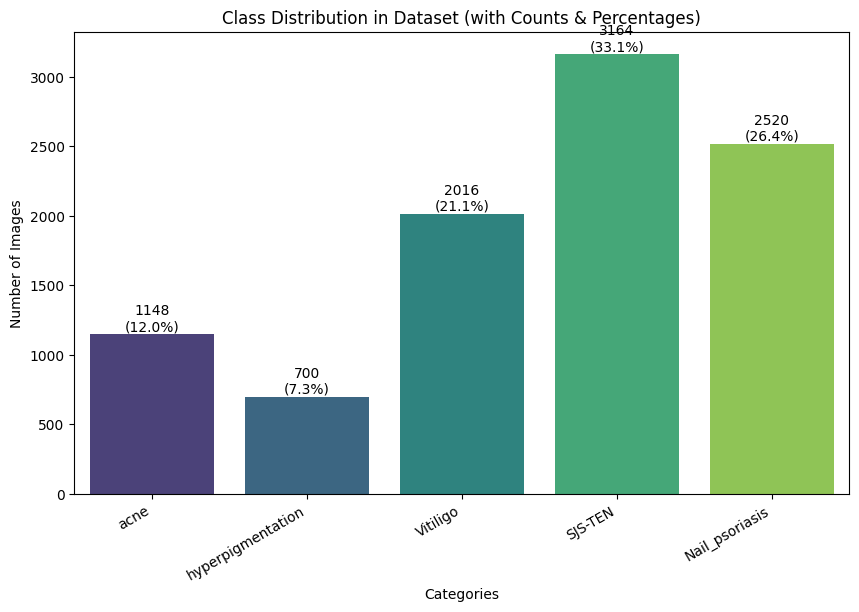

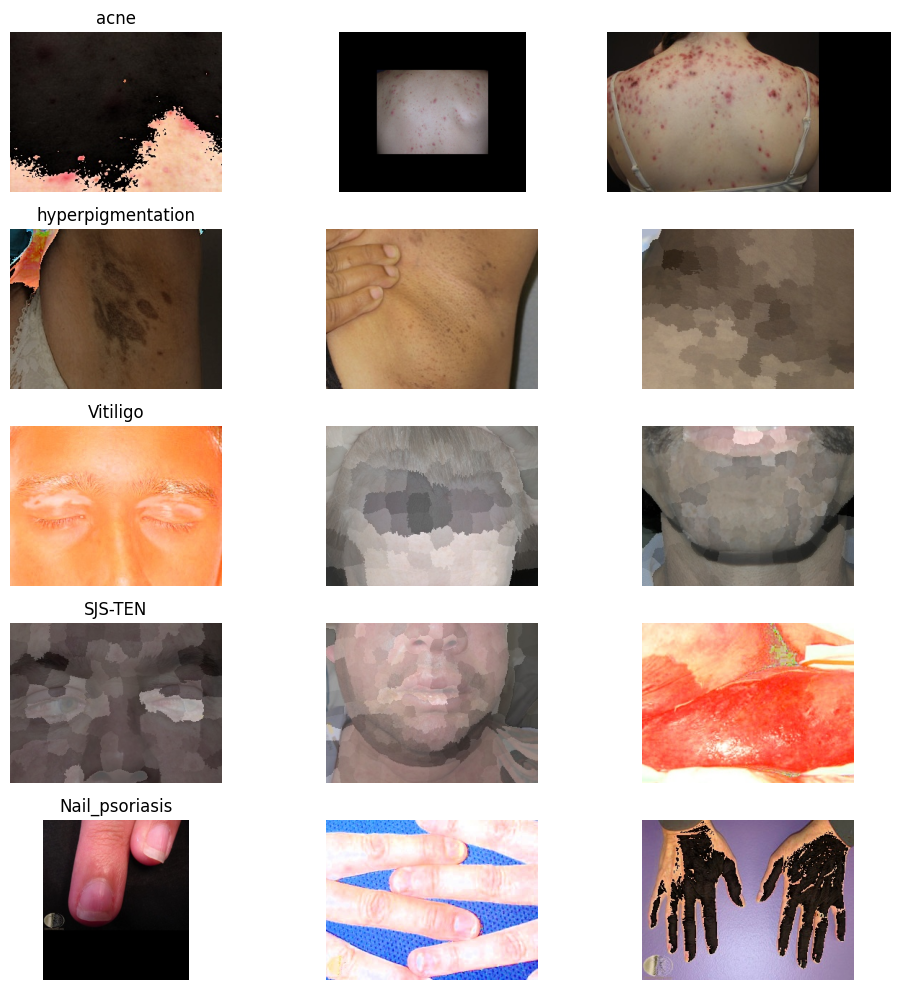

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ====================== 1️⃣ Class Distribution (Bar Plot) ======================

# Get class names and count images per category
categories = os.listdir(image_dir)
class_counts = {category: len(os.listdir(os.path.join(image_dir, category))) for category in categories}

# Convert to percentages
total_images = sum(class_counts.values())
class_percentages = {category: (count / total_images) * 100 for category, count in class_counts.items()}

# Plot class distribution with counts and percentages
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")

# Annotate each bar with count and percentage
for p, (category, count) in zip(ax.patches, class_counts.items()):
    percentage = class_percentages[category]
    ax.annotate(f"{count}\n({percentage:.1f}%)", (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

# Labels and title
plt.xticks(rotation=30, ha="right")
plt.xlabel("Categories")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Dataset (with Counts & Percentages)")
plt.show()

# ====================== 2️⃣ Display Sample Images ======================

# Function to display images from each category
def display_sample_images(image_dir, categories, samples_per_category=3):
    fig, axes = plt.subplots(len(categories), samples_per_category, figsize=(10, 10))

    for i, category in enumerate(categories):
        category_path = os.path.join(image_dir, category)
        images = os.listdir(category_path)[:samples_per_category]  # Pick some sample images

        for j, image_name in enumerate(images):
            img_path = os.path.join(category_path, image_name)
            img = plt.imread(img_path)  # Load image

            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            axes[i, j].set_title(category if j == 0 else "")

    plt.tight_layout()
    plt.show()

# Display images
display_sample_images(image_dir, categories)


# **BALANCING CLASSES USING DATA AGUMENTATION**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import shutil

# Custom function to balance classes via augmentation
def balance_classes(image_dir, target_samples=2500):
    for category in os.listdir(image_dir):
        category_path = os.path.join(image_dir, category)
        images = os.listdir(category_path)
        num_images = len(images)

        if num_images < target_samples:
            aug_count = target_samples - num_images
            datagen = ImageDataGenerator(
                rotation_range=30,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                brightness_range=[0.8, 1.2]
            )

            # Load images for augmentation
            for i in range(aug_count):
                img_name = np.random.choice(images)
                img_path = os.path.join(category_path, img_name)
                img = plt.imread(img_path)
                img = np.expand_dims(img, axis=0)  # Reshape for augmentation

                aug_iter = datagen.flow(img, batch_size=1)
                aug_img = next(aug_iter)[0].astype(np.uint8)

                # Save augmented image
                new_img_name = f"aug_{i}_{img_name}"
                plt.imsave(os.path.join(category_path, new_img_name), aug_img)

    print("✔ Classes balanced using augmentation!")

# Call function to balance dataset
balance_classes(image_dir, target_samples=3000)


✔ Classes balanced using augmentation!


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Corrected input for class weights calculation
all_labels = []  # Flattened list of all class labels (one per image)
for class_label, count in class_counts.items():
    all_labels.extend([class_label] * count)

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(all_labels), y=all_labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Computed Class Weights:", class_weights_dict)


Computed Class Weights: {0: np.float64(0.7577777777777778), 1: np.float64(0.6035398230088496), 2: np.float64(0.9472222222222222), 3: np.float64(1.6634146341463414), 4: np.float64(2.728)}


# **UP SCALING**

<ipython-input-8-cc9ee5510219>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(updated_class_counts.keys()), y=list(updated_class_counts.values()), palette="viridis")


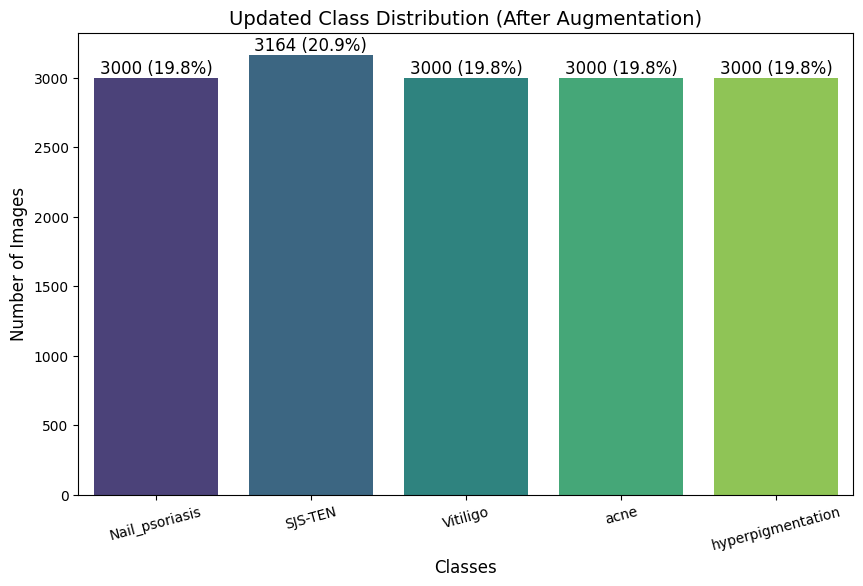

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Count images in each category
def count_images(image_dir):
    class_counts = {}
    for category in sorted(os.listdir(image_dir)):  # Sorted for consistent order
        category_path = os.path.join(image_dir, category)
        if os.path.isdir(category_path):
            class_counts[category] = len(os.listdir(category_path))
    return class_counts

# Get the new distribution
updated_class_counts = count_images(image_dir)

# Plot the bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=list(updated_class_counts.keys()), y=list(updated_class_counts.values()), palette="viridis")

# Display count and percentage on top of bars
total_images = sum(updated_class_counts.values())
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())} ({p.get_height() / total_images:.1%})',
                (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=12)

plt.title("Updated Class Distribution (After Augmentation)", fontsize=14)
plt.xlabel("Classes", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=15)
plt.show()


In [ ]:
import os
import random

# Define the target number of images for SJS-TEN
target_samples = 3000
class_to_downscale = "SJS-TEN"

# Path to SJS-TEN folder
sjs_ten_folder = os.path.join(image_dir, class_to_downscale)

# List all images
all_images = os.listdir(sjs_ten_folder)

# Check if downscaling is needed
if len(all_images) > target_samples:
    excess_images = random.sample(all_images, len(all_images) - target_samples)

    # Remove extra images
    for img in excess_images:
        os.remove(os.path.join(sjs_ten_folder, img))

    print(f"✔ Downscaled {class_to_downscale} to {target_samples} images.")

else:
    print(f"⚠ No downscaling needed, already at {len(all_images)} images.")


✔ Downscaled SJS-TEN to 3000 images.


# **DOWN SCALING**

<ipython-input-10-40381b1fd71b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(updated_class_counts.keys()), y=list(updated_class_counts.values()), palette="viridis")


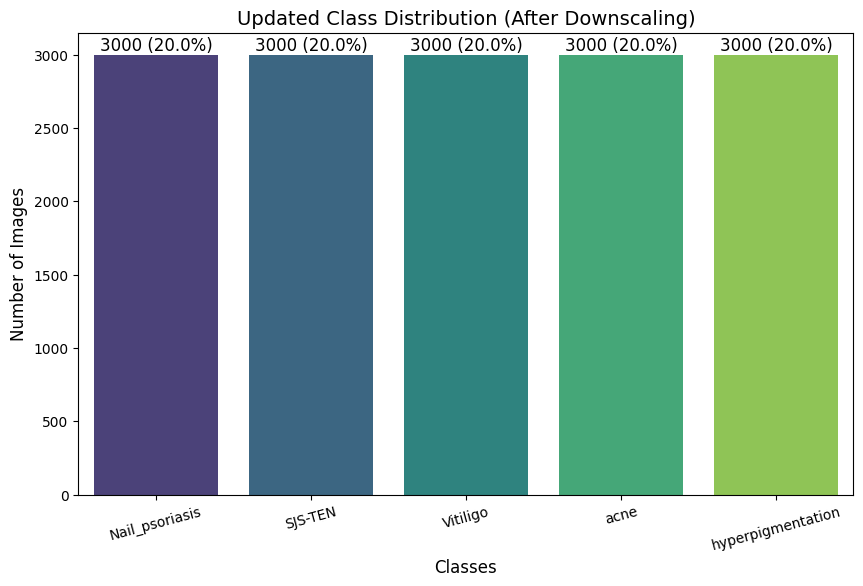

In [ ]:
# Count updated images in each class
updated_class_counts = count_images(image_dir)

# Replot class distribution
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=list(updated_class_counts.keys()), y=list(updated_class_counts.values()), palette="viridis")

# Annotate bar chart with count and percentage
total_images = sum(updated_class_counts.values())
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())} ({p.get_height() / total_images:.1%})',
                (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=12)

plt.title("Updated Class Distribution (After Downscaling)", fontsize=14)
plt.xlabel("Classes", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=15)
plt.show()


# AGUMENTED IMAGE VISUALIZATION

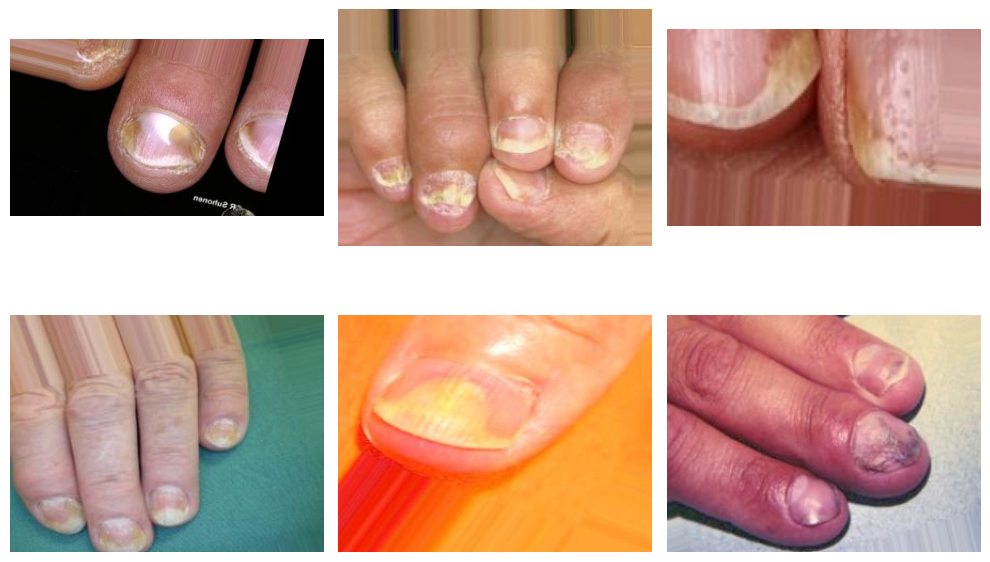

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Select a class folder to display augmented images
sample_class = list(updated_class_counts.keys())[0]  # Pick first class for example
sample_folder = os.path.join(image_dir, sample_class)

# Load augmented images (ignoring original ones)
augmented_images = [f for f in os.listdir(sample_folder) if f.startswith("aug_")][:6]  # Select first 6 augmented

# Display the images
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
axes = axes.flatten()

for img_name, ax in zip(augmented_images, axes):
    img_path = os.path.join(sample_folder, img_name)
    img = load_img(img_path)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()


# **CNN**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
image_dir = "/content/skin_disease_dataset/images"

# Data Augmentation & Normalization
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2
)

# Training Data Generator
train_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

# Validation Data Generator
val_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

# Build Custom CNN Model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(256, (3, 3), activation="relu"),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(train_generator.num_classes, activation="softmax")
])

# Compile Model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

# Evaluate Model
test_loss, test_acc = model.evaluate(val_generator)
print(f"✅ Test Accuracy: {test_acc:.2f}")


Found 12000 images belonging to 5 classes.
Found 3000 images belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1779s 5s/step - accuracy: 0.4012 - loss: 1.3744 - val_accuracy: 0.6073 - val_loss: 0.9787
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1716s 5s/step - accuracy: 0.6452 - loss: 0.9046 - val_accuracy: 0.7303 - val_loss: 0.7175
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1728s 5s/step - accuracy: 0.7719 - loss: 0.6141 - val_accuracy: 0.7863 - val_loss: 0.5924
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1710s 5s/step - accuracy: 0.8603 - loss: 0.3986 - val_accuracy: 0.8230 - val_loss: 0.5437
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1694s 5s/step - accuracy: 0.9052 - loss: 0.2746 - val_accuracy: 0.8117 - val_loss: 0.6415
94/94 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.8164 - loss: 0.6433
✅ Test Accuracy: 0.81


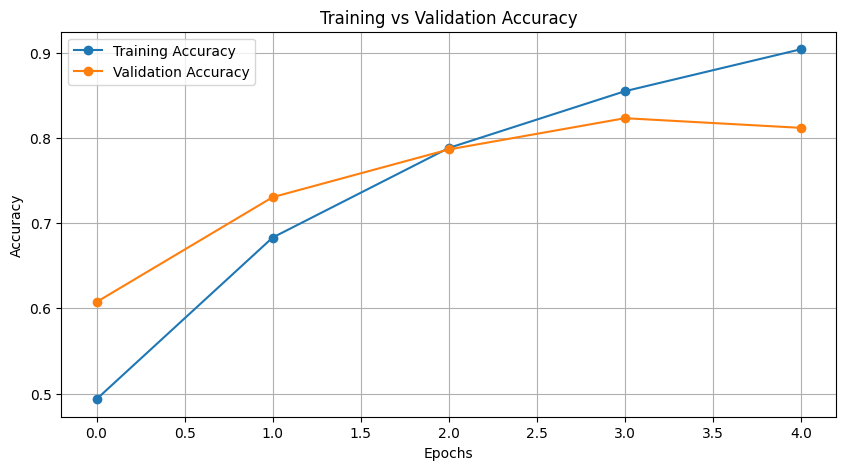

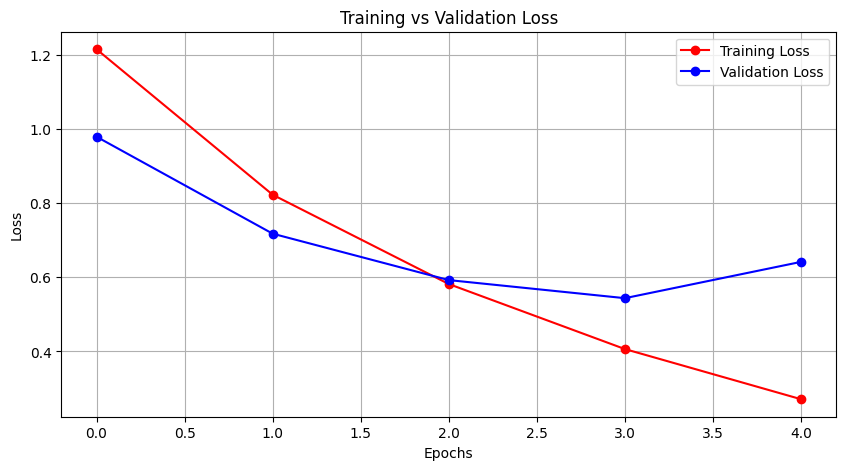

()

In [ ]:
import matplotlib.pyplot as plt

# 📌 Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label="Training Accuracy", marker="o")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# 📌 Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label="Training Loss", marker="o", color='red')
plt.plot(history.history['val_loss'], label="Validation Loss", marker="o", color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


94/94 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step


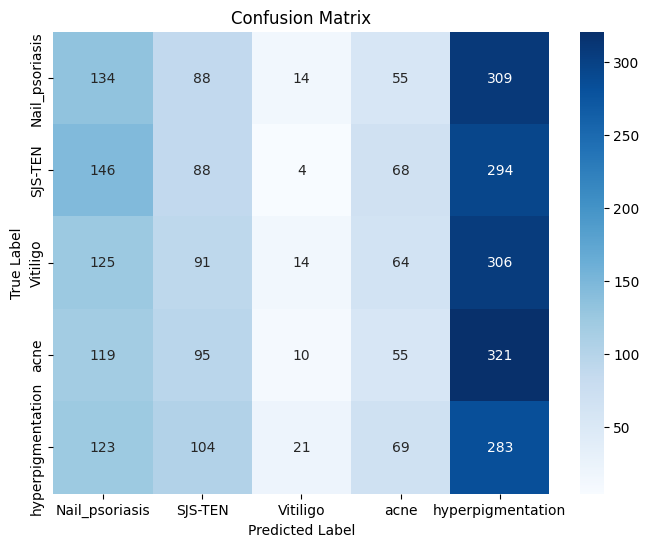

Classification Report:
                    precision    recall  f1-score   support

   Nail_psoriasis       0.21      0.22      0.21       600
          SJS-TEN       0.19      0.15      0.17       600
         Vitiligo       0.22      0.02      0.04       600
             acne       0.18      0.09      0.12       600
hyperpigmentation       0.19      0.47      0.27       600

         accuracy                           0.19      3000
        macro avg       0.20      0.19      0.16      3000
     weighted avg       0.20      0.19      0.16      3000



In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Get True Labels and Predictions
y_true = val_generator.classes  # Actual labels
y_pred = model.predict(val_generator)  # Predictions (probabilities)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=val_generator.class_indices.keys()))


# **EfficientNetV2**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
image_dir = "/content/skin_disease_dataset/images"

# Data Augmentation & Normalization
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    image_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', subset='training'
)

val_generator = datagen.flow_from_directory(
    image_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', subset='validation'
)

# Load Pretrained EfficientNetV2 Model
base_model = keras.applications.EfficientNetV2B0(
    include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights="imagenet"
)
base_model.trainable = False  # Freeze Pretrained Layers

# Custom Model
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(train_generator.num_classes, activation="softmax")
])

# Compile Model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss="categorical_crossentropy", metrics=["accuracy"])

# Train Model
history = model.fit(train_generator, validation_data=val_generator, epochs=5)

# Evaluate Model
test_loss, test_acc = model.evaluate(val_generator)
print(f"✅ Test Accuracy: {test_acc:.2f}")


Found 7639 images belonging to 7 classes.
Found 1909 images belonging to 7 classes.
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 656s 3s/step - accuracy: 0.7816 - loss: 0.6012 - val_accuracy: 0.7999 - val_loss: 0.5052
Epoch 2/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 578s 2s/step - accuracy: 0.7989 - loss: 0.5184 - val_accuracy: 0.7999 - val_loss: 0.5009
Epoch 3/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 564s 2s/step - accuracy: 0.7958 - loss: 0.5113 - val_accuracy: 0.7999 - val_loss: 0.5030
Epoch 4/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 561s 2s/step - accuracy: 0.7981 - loss: 0.5099 - val_accuracy: 0.7999 - val_loss: 0.5037
Epoch 5/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 585s 2s/step - accuracy: 0.7929 - loss: 0.5168 - val_accuracy: 0.7999 - val_loss: 0.5023
60/60 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.8009 - loss: 0.5009
✅ Test Accuracy: 0.80


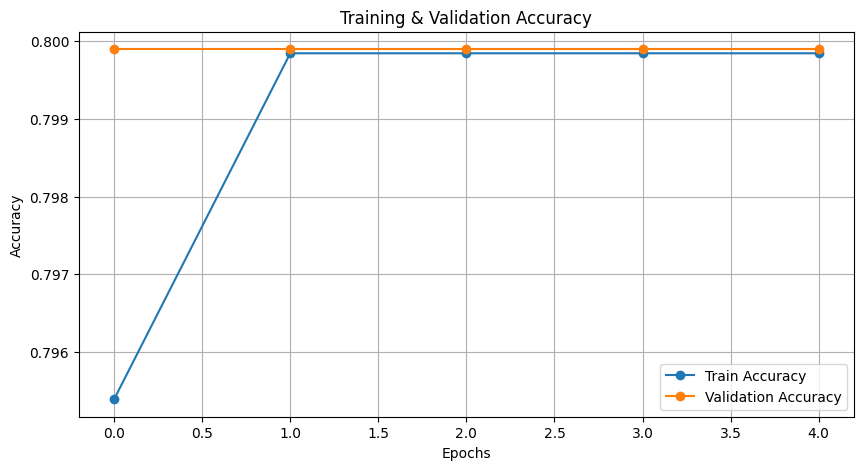

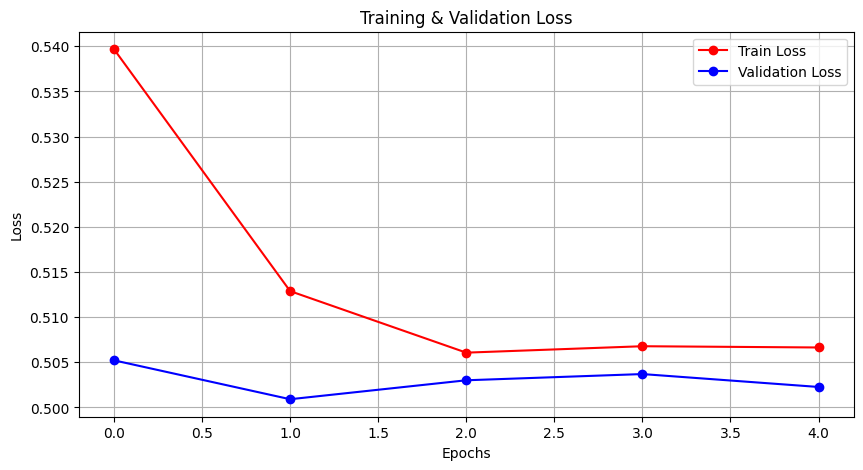

In [ ]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid()
plt.show()


# **XAI**

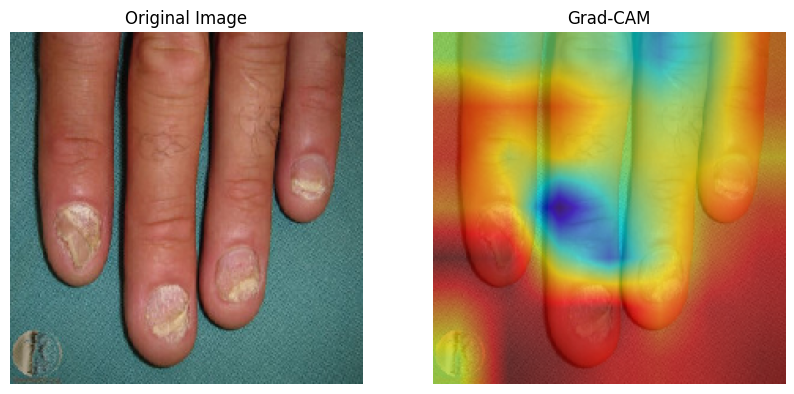

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

def preprocess_image(img_path, img_size=224):
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return img_array, img

def make_gradcam_heatmap(model, img_array, layer_name):
    grad_model = Model(inputs=model.input,
                       outputs=[model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, tf.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

def overlay_heatmap(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(np.array(img), alpha, heatmap, 1 - alpha, 0)
    return overlay

# Load Pretrained Model
base_model = EfficientNetB0(weights="imagenet")
base_model = Model(inputs=base_model.input, outputs=base_model.output)

# Image Path (Change this to your image path)
img_path = "/content/skin_disease_dataset/images/train/Nail_psoriasis/3238__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpeg"
img_array, original_img = preprocess_image(img_path)

# Generate Grad-CAM Heatmap
heatmap = make_gradcam_heatmap(base_model, img_array, "top_activation")

# Overlay Heatmap on Image
superimposed_img = overlay_heatmap(original_img, heatmap)

# Display Results
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(superimposed_img)
plt.axis("off")
plt.show()


# Vision Transformer (ViT) LIME (Local Interpretable Model-agnostic Explanations)

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=8f47afcbfb660fbb3023889afc5ddc3a3e481b8bcc9208789466656c772277a4
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


  0%|          | 0/1000 [00:00<?, ?it/s]

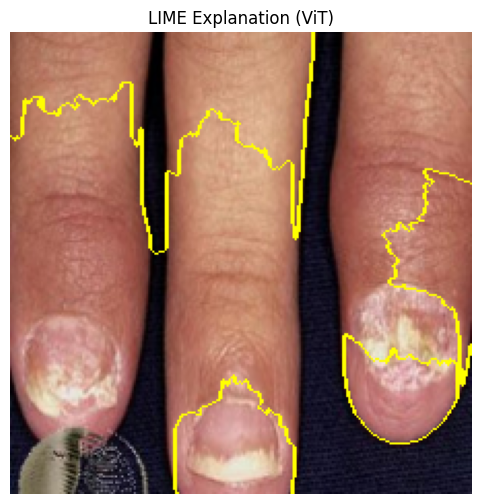

In [ ]:
import numpy as np
import torch
import timm
import matplotlib.pyplot as plt
from lime import lime_image
from torchvision import transforms
from skimage.segmentation import mark_boundaries
from PIL import Image

# ✅ Step 1: Load ViT Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True).to(device)
vit_model.eval()  # Set model to evaluation mode

# ✅ Step 2: Define Image Preprocessing for ViT
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # ViT normalization
])

# ✅ Step 3: Load and Preprocess the Image
img_path = "/content/skin_disease_dataset/images/train/Nail_psoriasis/3231__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsInkiLDM2XQ.jpeg"  # Change to your image path
img = Image.open(img_path).convert("RGB")  # Open image
test_image = preprocess(img).unsqueeze(0).to(device)  # (1, 3, 224, 224)

# ✅ Step 4: Define Classifier Function for LIME
def classifier_fn(images):
    """
    Classifier function for LIME that takes a batch of images and returns predictions.
    """
    images = torch.tensor(images).permute(0, 3, 1, 2)  # Convert (N, H, W, C) → (N, C, H, W)
    images = (images - 0.5) / 0.5  # Normalize
    images = images.to(device, dtype=torch.float32)

    with torch.no_grad():
        logits = vit_model(images)  # Get raw predictions
        probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()  # Convert to probabilities

    return probs  # Return probabilities for LIME

# ✅ Step 5: Generate LIME Explanation
explainer = lime_image.LimeImageExplainer()
test_image_2d = np.array(img.resize((224, 224))) / 255.0  # Convert PIL image to NumPy array

explanation = explainer.explain_instance(
    test_image_2d.astype('double'),
    classifier_fn=classifier_fn,
    top_labels=3,
    hide_color=0,
    num_samples=1000,
)

# ✅ Step 6: Visualize LIME Explanation
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False
)
plt.figure(figsize=(6, 6))
plt.imshow(mark_boundaries(temp, mask))
plt.axis("off")
plt.title("LIME Explanation (ViT)")
plt.show()
